https://www.sciencedirect.com/science/article/pii/S1568494620306803?casa_token=4ieLFywpVeUAAAAA:PeXRbdBj46bl9y-0SZOOE30EekImtXEMDC592HLOaOSNjKVMLBh5a9-MKeVbrATUJE8RwrSl#b26

# Import Packages

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd "/content/drive/My Drive/MIE424/Exploring-Optimization-in-Deep-Learning-with-Various-Algorithms/Notebooks"

/content/drive/.shortcut-targets-by-id/1-0yfWCW69kavV8g4Zyl8jxmL2psN6QQU/MIE424/Exploring-Optimization-in-Deep-Learning-with-Various-Algorithms/Notebooks


In [ ]:
!pip install import-ipynb
import import_ipynb

  Created wheel for import-ipynb: filename=import_ipynb-0.1.3-py3-none-any.whl size=2975 sha256=e04e8e4eaf12bc2c47e7031b49405d03cedea101ff38239c26feb8e9016775d4
  Stored in directory: /root/.cache/pip/wheels/b1/5e/dc/79780689896a056199b0b9f24471e3ee184fbd816df355d5f0
Successfully built import-ipynb


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import time 
import torch

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import datasets, transforms

from torch.optim import Optimizer
from torch.distributions import Bernoulli, Normal
import torchvision.models

from copy import deepcopy

In [ ]:
import Optimizers

importing Jupyter notebook from Optimizers.ipynb


In [ ]:
# import misc

# Get Data Loader

In [ ]:
def get_data_loader(target_classes, batch_size, num_workers):
    np.random.seed(1000) # fixed numpy seed for reproducible shuffling
    classes = ['Covid Negative', 'Covid Positive'] # classes are folders in each directory with these names

    tensor_data_path = "/content/drive/My Drive/MIE424/Exploring-Optimization-in-Deep-Learning-with-Various-Algorithms/Data/Tensor/"
    data = torchvision.datasets.DatasetFolder(tensor_data_path, loader=torch.load, extensions=('.pt')) # stored in tensors
    
    relevant_indices = list(range(len(data)))
    np.random.shuffle(relevant_indices)
    # relevant_indices = relevant_indices[0:1000]

    # Splitting data: 70% train, 15% validation, 15% test
    train_val_split = int(len(relevant_indices) * 0.7)
    val_test_split = int(len(relevant_indices) * 0.85)
    relevant_train_indices, relevant_val_indices, relevant_test_indices = relevant_indices[:train_val_split], relevant_indices[train_val_split:val_test_split], relevant_indices[val_test_split:]

    train_sampler = SubsetRandomSampler(relevant_train_indices)
    train_loader = torch.utils.data.DataLoader(data, batch_size=batch_size, num_workers=num_workers, sampler=train_sampler, drop_last=True)
    
    val_sampler = SubsetRandomSampler(relevant_val_indices) 
    val_loader = torch.utils.data.DataLoader(data, batch_size=batch_size, num_workers=num_workers, sampler=val_sampler, drop_last=True)

    test_sampler = SubsetRandomSampler(relevant_test_indices) 
    test_loader = torch.utils.data.DataLoader(data, batch_size=batch_size, num_workers=num_workers, sampler=test_sampler, drop_last=True)

    return train_loader, val_loader, test_loader, classes

# Training Code

In [ ]:
# Generate a name for each training hyperparameter settings, which is a string consisting of all hyperparameters of a model
def get_model_name(name, batch_size, learning_rate, epoch):
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path  #get a string consisting of all hyperparameters of a model

In [ ]:
def normalize_label(labels):
    """
    Given a tensor containing 2 possible values, normalize this to 0/1

    Args:
        labels: a 1D tensor containing two possible scalar values
    Returns:
        A tensor normalize to 0/1 value
    """
    max_val = torch.max(labels)
    min_val = torch.min(labels)
    norm_labels = (labels - min_val)/(max_val - min_val)
    return norm_labels

In [ ]:
def evaluate(net, loader, criterion):
    total_loss = 0.0
    total_err = 0.0
    total_epoch = 0
    for i, data in enumerate(loader, 0):
        inputs, labels = data
        if use_cuda and torch.cuda.is_available():
          inputs = inputs.cuda()
          labels = labels.cuda()
        labels = normalize_label(labels)  # Convert labels to 0/1
        outputs = net(inputs)

        loss = criterion(outputs+1e-10, labels.float())
        corr = (outputs > 0.0).squeeze().long() != labels
        total_err += int(corr.sum())
        total_loss += loss.item()
        total_epoch += len(labels.tolist())

    err = float(total_err) / total_epoch
    loss = float(total_loss) / (i + 1)
    return err, loss

In [ ]:
def train(model, train_data, val_data, optimizer, batch_size=64, learning_rate=0.001, num_epochs=1):
    # Fixed PyTorch random seed for reproducible result
    torch.manual_seed(1000)
    
    # train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
    # val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=True)
    criterion = nn.BCEWithLogitsLoss()
    # optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    train_loss = np.zeros(num_epochs)
    train_err = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)
    val_err = np.zeros(num_epochs)
    
    
    # training
    start_time = time.time()
    for epoch in range(num_epochs):
        total_train_loss = 0.0
        
        for i, data in enumerate(train_loader):
            inputs, labels = data # Get the inputs
            if use_cuda and torch.cuda.is_available():
              inputs = inputs.cuda()
              labels = labels.cuda()

            out = model(inputs)             # forward pass
            loss = criterion(out+1e-10, labels.float()) # compute the total loss
            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         # a clean up step for PyTorch

            # Save the current training information
            total_train_loss += loss.item()             # compute train loss
        
        # Calculate error and loss for training and validation set for this epoch
        train_err[epoch], train_loss[epoch] = evaluate(model, train_loader, criterion)   # compute average train error and loss
        val_err[epoch], val_loss[epoch] = evaluate(model, val_loader, criterion)   # compute validation error and loss
        print(("Epoch {}: Train err: {}, Train loss: {} | "+
               "Val err: {}, Val loss: {} | Time: {:.2f}").format(
                   epoch + 1,
                   train_err[epoch],
                   train_loss[epoch],
                   val_err[epoch],
                   val_loss[epoch], 
                   time.time() - start_time))
        
        # Save the current model (checkpoint) to a file, every 10 epoch - always save the last epoch
        if (epoch % 10 == 0) or (epoch == num_epochs-1):
          model_path = get_model_name(model.name, batch_size, learning_rate, epoch)
          torch.save(model.state_dict(), model_path)
        
    print('Finished Training')
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Total time elapsed: {:.2f} seconds".format(elapsed_time))
    
    # Write the train/test loss/accuracy into CSV file for plotting later
    epochs = np.arange(1, num_epochs + 1)
    model_path = get_model_name(model.name, batch_size, learning_rate, num_epochs)
    np.savetxt("{}_train_err.csv".format(model_path), train_err)
    np.savetxt("{}_train_loss.csv".format(model_path), train_loss)
    np.savetxt("{}_val_err.csv".format(model_path), val_err)
    np.savetxt("{}_val_loss.csv".format(model_path), val_loss)

    print("Final Training Error: {}".format(train_err[-1]))

In [ ]:
def plot_training_curve(path, epochs=1):
    # Load the training and validation accuracy and loss
    train_acc = np.loadtxt("{}_train_err.csv".format(path))
    val_acc = np.loadtxt("{}_val_err.csv".format(path))
    train_loss = np.loadtxt("{}_train_loss.csv".format(path))
    val_loss = np.loadtxt("{}_val_loss.csv".format(path))
    
    plt.title("Train vs Validation Classification Error")
    plt.plot(range(1,epochs+1), train_acc, label="Train")
    plt.plot(range(1,epochs+1), val_acc, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Classification Error")
    plt.legend(loc='best')
    plt.show()
    
    plt.title("Train vs Validation Loss")
    plt.plot(range(1,epochs+1), train_loss, label="Train")
    plt.plot(range(1,epochs+1), val_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    
    plt.show()

# misc for Optimizers

https://github.com/nicklashansen/neural-net-optimization/blob/master/misc.py

In [ ]:
optim_dict = {
		'sgd': {
			'label': 'SGD',
			'lr': 1e-3
		},
		'sgd_momentum': {
			'label': 'SGD w/ momentum',
			'lr': 1e-3,
			'mu': 0.99
		},
		'sgd_nesterov': {
			'label': 'SGD w/ Nesterov momentum',
			'lr': 1e-3,
			'mu': 0.99,
			'nesterov': True
		},
		'sgd_weight_decay': {
			'label': 'SGDW',
			'lr': 1e-3,
			'mu': 0.99,
			'weight_decay': 1e-6
		},
		'sgd_lrd': {
			'label': 'SGD w/ momentum + LRD',
			'lr': 1e-3,
			'mu': 0.99,
			'lrd': 0.5
		},
		'adam': {
			'label': 'Adam',
			'lr': 1e-3
		},
		'adamW':{
			'label': 'AdamW',
			'lr': 1e-3,
			'weight_decay': 1e-4
		},
		'adam_l2':{
			'label': 'AdamL2',
			'lr': 1e-3,
			'l2_reg': 1e-4
		},
		'adam_lrd': {
			'label': 'Adam w/ LRD',
			'lr': 1e-3,
			'lrd': 0.5
		},
		'Radam': {
			'label': 'RAdam',
			'lr': 1e-3,
			'rectified': True
		},
		'RadamW': {
			'label': 'RAdamW',
			'lr': 1e-3,
			'rectified': True,
			'weight_decay': 1e-4
		},
		'Radam_lrd': {
			'label': 'RAdam w/ LRD',
			'lr': 1e-3,
			'rectified': True,
			'lrd': 0.5
		},
		'nadam': {
			'label': 'Nadam',
			'lr': 1e-3,
			'nesterov': True
		},
		'rmsprop': {
			'label': 'RMSprop',
			'lr': 1e-3,
			'beta2': 0.9,
		},
		'lookahead_sgd': {
			'label': 'Lookahead (SGD)',
			'lr': 1e-3,
			'mu': 0.99
		},
		'lookahead_adam': {
			'label': 'Lookahead (Adam)',
			'lr': 1e-3
		},
		'gradnoise_adam': {
			'label': 'Gradient Noise (Adam)',
			'lr': 1e-3
		},
		'graddropout_adam': {
			'label': 'Gradient Dropout (Adam)',
			'lr': 1e-3
		}
	}

In [ ]:
def split_optim_dict(d:dict) -> tuple:
	"""
	Splits an optimization dict into label and dict.
	"""
	temp_d = deepcopy(d)
	label = temp_d['label']
	del temp_d['label']

	return label, temp_d

In [ ]:
def task_to_optimizer(task:str) -> torch.optim.Optimizer:
	"""
	Takes a task as string and returns its respective optimizer class.
	"""
	optimizer = None

	if 'sgd' in task.lower():
		optimizer = getattr(Optimizers, 'SGD')
	if 'adam' in task.lower():
		optimizer = getattr(Optimizers, 'Adam')
	if 'rmsprop' in task.lower():
		optimizer = getattr(Optimizers, 'RMSProp')
	
	if optimizer is None:
		raise ValueError(f'Optimizer for task \'{task}\' was not recognized!')

	return optimizer

In [ ]:
def wrap_optimizer(task:str, optimizer):
	"""
	Wraps an instantiated optimizer according to its task specified as a string.
	"""
	if 'gradnoise' in task.lower():
		optimizer = Optimizers.GradientNoise(optimizer, eta=0.3, gamma=0.55)

	if 'graddropout' in task.lower():
		optimizer = Optimizers.GradientDropout(optimizer, grad_retain=0.9)

	if 'lookahead' in task.lower():
		optimizer = Optimizers.Lookahead(optimizer, k=5, alpha=0.5)

	return optimizer

# Model Training

In [ ]:
# get number of images in training, validation, and testing sets
# print('Num in training set:',len(train_loader)*batch_size)
# print('Num in validation set:',len(val_loader)*batch_size)
# print('Num in testing set:',len(test_loader)*batch_size)

In [ ]:
# Visualize some sample data
# dataiter = iter(train_loader)
# images,labels = dataiter.next()
# images = images.numpy()
# classes = ['Covid Negative', 'Covid Positive']
# # plot the images in the batch, along with corresponding labels
# fig = plt.figure(figsize=(25,4))
# for idx in np.arange(20):
#   ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
#   plt.imshow(np.transpose(images[idx], (1, 2, 0)))
#   ax.set_title(classes[labels[idx]])

In [ ]:
# model = torch.hub.load('pytorch/vision:v0.10.0', 'densenet121', pretrained=True)
# or any of these variants
# model = torch.hub.load('pytorch/vision:v0.10.0', 'densenet169', pretrained=True)
# model = torch.hub.load('pytorch/vision:v0.10.0', 'densenet201', pretrained=True)
# model = torch.hub.load('pytorch/vision:v0.10.0', 'densenet161', pretrained=True)
#model.eval()

# num_ftrs = model.classifier.in_features
# model.classifier = nn.Linear(num_ftrs, 340)
# model.features.conv0.apply(squeeze_weights)
# model.classifier2 = nn.Linear(340, 1)

In [ ]:
# model = torch.hub.load('pytorch/vision:v0.10.0', 'densenet121', pretrained=True)
# model.classifier.in_features

In [ ]:
opt_tasks = [
		'sgd',
		'sgd_momentum',
		'sgd_nesterov',
		'sgd_weight_decay',
		'sgd_lrd',
		'rmsprop',
		'adam',
		'adam_l2',
		'adamW',
		'adam_lrd',
		'Radam',
		'RadamW',
		'Radam_lrd',
		'nadam',
		'lookahead_sgd',
		'lookahead_adam',
		'gradnoise_adam',
		'graddropout_adam'
	]

https://www.kaggle.com/code/leighplt/densenet121-pytorch/notebook

In [ ]:
class TransferDenseNet121Classifier_Adam(nn.Module):
    def __init__(self):
        super(TransferDenseNet121Classifier_Adam, self).__init__()
        self.name = 'densenet121Classifier_adam'
        preloaded = torch.hub.load('pytorch/vision:v0.10.0', 'densenet121', pretrained=True)
        self.features = preloaded.features

        self.features.conv0 = nn.Conv2d(3, 64, 7, 2, 3)
        # self.num_ftrs = self.model.classifier.in_features
        self.fc1 = nn.Linear(1024, 340)
        self.fc2 = nn.Linear(340, 1)
        del preloaded
    
    def forward(self, x):
        features = self.features(x)
        x = F.relu(features, inplace=True)
        # x = x.view(-1, self.num_ftrs)
        # x = F.relu(features, inplace=True)
        x = F.adaptive_avg_pool2d(x, (1, 1)).view(features.size(0), -1)

        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = x.squeeze(1)
        return x

In [ ]:
class TransferDenseNet121Classifier_AdamLRD(nn.Module):
    def __init__(self):
        super(TransferDenseNet121Classifier_AdamLRD, self).__init__()
        self.name = 'densenet121Classifier_adamLRD'
        preloaded = torch.hub.load('pytorch/vision:v0.10.0', 'densenet121', pretrained=True)
        self.features = preloaded.features

        self.features.conv0 = nn.Conv2d(3, 64, 7, 2, 3)
        # self.num_ftrs = self.model.classifier.in_features
        self.fc1 = nn.Linear(1024, 340)
        self.fc2 = nn.Linear(340, 1)
        del preloaded
    
    def forward(self, x):
        features = self.features(x)
        x = F.relu(features, inplace=True)
        # x = x.view(-1, self.num_ftrs)
        # x = F.relu(features, inplace=True)
        x = F.adaptive_avg_pool2d(x, (1, 1)).view(features.size(0), -1)

        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = x.squeeze(1)
        return x

* SGD (Amanda), SGD w/ momentum (Coco), SGD w/ Nesterov momentum (Amanda), SGD w/ LRD (Coco)
* Adam (Nancy), Adam w/ L2 (Kelly), Adam w/ LRD (Nancy), AdamW (Kelly)
* KO optimizer

hyperparameter combinations:
1. bs=32, lr=0.01, num_epochs=30
2. bs=32, lr=0.001, num_epochs=30
3. bs=64, lr=0.01, num_epochs=30
4. bs=64, lr=0.001, num_epochs=30
5. bs=128, lr=0.01, num_epochs=30
6. bs=128, lr=0.001, num_epochs=30

### Adam

In [ ]:
bs_list = [32]
lr_list = [0.02]
for bs in bs_list:
  for lr in lr_list:
    # Train with batch size and learning rate
    print('batch size = {}, learning rate = {}'.format(bs, lr))
    train_loader, val_loader, test_loader, classes = get_data_loader(['Covid Negative', 'Covid Positive'], bs, 1)
    use_cuda = True
    model = TransferDenseNet121Classifier_Adam()
    _, kwargs = split_optim_dict(optim_dict['adam'])
    optimizer = task_to_optimizer('adam')(params=model.parameters(), **kwargs)
    optimizer = wrap_optimizer('adam', optimizer)
    if use_cuda and torch.cuda.is_available():
      model.cuda()
      print("Training with CUDA!")
    else:
      print("CUDA not available...")
    train(model, train_loader, val_loader, optimizer, batch_size=bs, learning_rate=lr, num_epochs=30)

    # Plotting
    model_path = get_model_name('densenet121Classifier_adam', batch_size=bs, learning_rate=lr, epoch=30)
    plot_training_curve(model_path, epochs=30)

batch size = 32, learning rate = 0.02


Downloading: "https://github.com/pytorch/vision/archive/v0.10.0.zip" to /root/.cache/torch/hub/v0.10.0.zip
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


  0%|          | 0.00/30.8M [00:00<?, ?B/s]

Training with CUDA!
Epoch 1: Train err: 0.19375, Train loss: 0.4225399805439843 | Val err: 0.20833333333333334, Val loss: 0.4454140232668983 | Time: 211.30
Epoch 2: Train err: 0.15902777777777777, Train loss: 0.3620751364363564 | Val err: 0.18055555555555555, Val loss: 0.39872778455416363 | Time: 261.55
Epoch 3: Train err: 0.1875, Train loss: 0.3956741038295958 | Val err: 0.19444444444444445, Val loss: 0.4506453507476383 | Time: 310.19
Epoch 4: Train err: 0.1875, Train loss: 0.357010226448377 | Val err: 0.2048611111111111, Val loss: 0.3935069723261727 | Time: 359.32
Epoch 5: Train err: 0.1625, Train loss: 0.3238755613565445 | Val err: 0.1701388888888889, Val loss: 0.36587369607554543 | Time: 408.46
Epoch 6: Train err: 0.11736111111111111, Train loss: 0.27333776305119195 | Val err: 0.13541666666666666, Val loss: 0.29966119925181073 | Time: 457.42
Epoch 7: Train err: 0.09791666666666667, Train loss: 0.225377871758408 | Val err: 0.13541666666666666, Val loss: 0.32338645723130965 | Time: 5

batch size = 32, learning rate = 0.01


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Training with CUDA!
Epoch 1: Train err: 0.21180555555555555, Train loss: 0.4251925554540422 | Val err: 0.20833333333333334, Val loss: 0.45146582192844814 | Time: 51.55
Epoch 2: Train err: 0.15138888888888888, Train loss: 0.35908986462487114 | Val err: 0.1736111111111111, Val loss: 0.3867720564206441 | Time: 98.69
Epoch 3: Train err: 0.2048611111111111, Train loss: 0.38636986878183155 | Val err: 0.2326388888888889, Val loss: 0.44806795650058323 | Time: 145.52
Epoch 4: Train err: 0.19583333333333333, Train loss: 0.4258513775136736 | Val err: 0.2013888888888889, Val loss: 0.4513381818930308 | Time: 192.13
Epoch 5: Train err: 0.1375, Train loss: 0.3075736161735323 | Val err: 0.18055555555555555, Val loss: 0.3975059125158522 | Time: 238.81
Epoch 6: Train err: 0.09930555555555555, Train loss: 0.24141290518972608 | Val err: 0.11805555555555555, Val loss: 0.29401406314637923 | Time: 285.66
Epoch 7: Train err: 0.09305555555555556, Train loss: 0.22764276762803395 | Val err: 0.14583333333333334, 

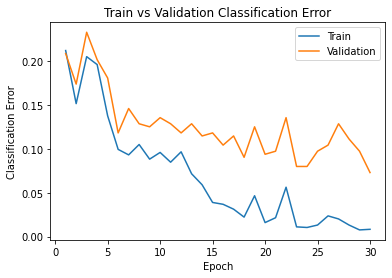

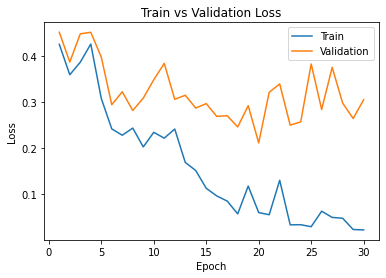

batch size = 32, learning rate = 0.001


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Training with CUDA!
Epoch 1: Train err: 0.20416666666666666, Train loss: 0.4186419917477502 | Val err: 0.2013888888888889, Val loss: 0.41868642965952557 | Time: 47.36
Epoch 2: Train err: 0.18263888888888888, Train loss: 0.36038733654552035 | Val err: 0.2013888888888889, Val loss: 0.4301120440165202 | Time: 94.27
Epoch 3: Train err: 0.16458333333333333, Train loss: 0.3481016867690616 | Val err: 0.2222222222222222, Val loss: 0.4584858914216359 | Time: 140.68
Epoch 4: Train err: 0.13819444444444445, Train loss: 0.31677724089887405 | Val err: 0.16319444444444445, Val loss: 0.38553182946311104 | Time: 187.31
Epoch 5: Train err: 0.11736111111111111, Train loss: 0.283539816737175 | Val err: 0.17708333333333334, Val loss: 0.36572331686814624 | Time: 233.92
Epoch 6: Train err: 0.09791666666666667, Train loss: 0.23942852285173205 | Val err: 0.15625, Val loss: 0.3173255009783639 | Time: 280.50
Epoch 7: Train err: 0.08958333333333333, Train loss: 0.22354733049869538 | Val err: 0.13541666666666666,

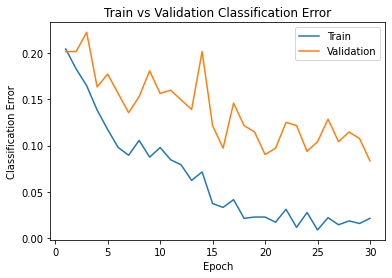

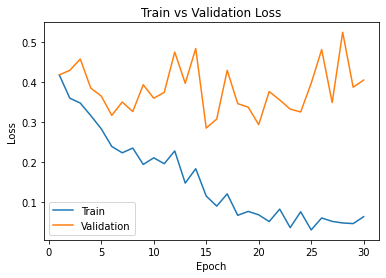

batch size = 64, learning rate = 0.01


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Training with CUDA!
Epoch 1: Train err: 0.16193181818181818, Train loss: 0.32275089689276437 | Val err: 0.1953125, Val loss: 0.3879782408475876 | Time: 36.95
Epoch 2: Train err: 0.14275568181818182, Train loss: 0.3316307880661704 | Val err: 0.15234375, Val loss: 0.3387201726436615 | Time: 73.25
Epoch 3: Train err: 0.1171875, Train loss: 0.255690027366985 | Val err: 0.15234375, Val loss: 0.3143324628472328 | Time: 109.35
Epoch 4: Train err: 0.09517045454545454, Train loss: 0.22483588416468014 | Val err: 0.13671875, Val loss: 0.33951570838689804 | Time: 145.32
Epoch 5: Train err: 0.06889204545454546, Train loss: 0.16025179929353975 | Val err: 0.09765625, Val loss: 0.2505528926849365 | Time: 181.31
Epoch 6: Train err: 0.07173295454545454, Train loss: 0.17065446705303408 | Val err: 0.14453125, Val loss: 0.3694990798830986 | Time: 217.35
Epoch 7: Train err: 0.1015625, Train loss: 0.2309212623672052 | Val err: 0.15234375, Val loss: 0.38358182087540627 | Time: 253.43
Epoch 8: Train err: 0.037

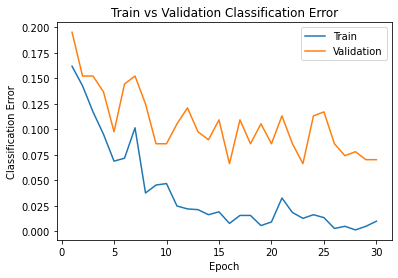

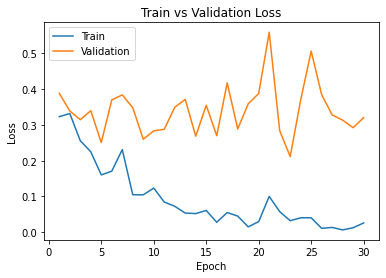

batch size = 64, learning rate = 0.001


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Training with CUDA!
Epoch 1: Train err: 0.13920454545454544, Train loss: 0.30951270393349906 | Val err: 0.21875, Val loss: 0.37957047671079636 | Time: 36.97
Epoch 2: Train err: 0.11505681818181818, Train loss: 0.26077844202518463 | Val err: 0.15234375, Val loss: 0.3163008615374565 | Time: 73.41
Epoch 3: Train err: 0.11860795454545454, Train loss: 0.2867562560872598 | Val err: 0.1640625, Val loss: 0.3586438000202179 | Time: 109.42
Epoch 4: Train err: 0.10653409090909091, Train loss: 0.233742932704362 | Val err: 0.1640625, Val loss: 0.3766831234097481 | Time: 145.52
Epoch 5: Train err: 0.078125, Train loss: 0.19688931649381464 | Val err: 0.1328125, Val loss: 0.3331088274717331 | Time: 181.64
Epoch 6: Train err: 0.04971590909090909, Train loss: 0.12307662313634699 | Val err: 0.12109375, Val loss: 0.2711540684103966 | Time: 217.68
Epoch 7: Train err: 0.04758522727272727, Train loss: 0.12043324316089804 | Val err: 0.09375, Val loss: 0.2506258003413677 | Time: 253.71
Epoch 8: Train err: 0.02

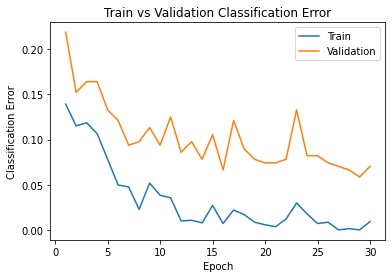

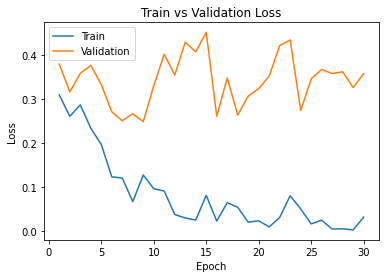

batch size = 128, learning rate = 0.01


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Training with CUDA!


RuntimeError: ignored

In [ ]:
bs_list = [32, 64]
lr_list = [0.01, 0.001]
for bs in bs_list:
  for lr in lr_list:
    # Train with batch size and learning rate
    print('batch size = {}, learning rate = {}'.format(bs, lr))
    train_loader, val_loader, test_loader, classes = get_data_loader(['Covid Negative', 'Covid Positive'], bs, 1)
    use_cuda = True
    model = TransferDenseNet121Classifier_Adam()
    _, kwargs = split_optim_dict(optim_dict['adam'])
    optimizer = task_to_optimizer('adam')(params=model.parameters(), **kwargs)
    optimizer = wrap_optimizer('adam', optimizer)
    if use_cuda and torch.cuda.is_available():
      model.cuda()
      print("Training with CUDA!")
    else:
      print("CUDA not available...")
    train(model, train_loader, val_loader, optimizer, batch_size=bs, learning_rate=lr, num_epochs=30)

    # Plotting
    model_path = get_model_name('densenet121Classifier_adam', batch_size=bs, learning_rate=lr, epoch=30)
    plot_training_curve(model_path, epochs=30)

### Adam w/ LRD

batch size = 32, learning rate = 0.01


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Training with CUDA!
Epoch 1: Train err: 0.1388888888888889, Train loss: 0.31376043525007036 | Val err: 0.16666666666666666, Val loss: 0.3663421372572581 | Time: 49.03
Epoch 2: Train err: 0.10347222222222222, Train loss: 0.265565957625707 | Val err: 0.15625, Val loss: 0.4002501600318485 | Time: 96.17
Epoch 3: Train err: 0.11388888888888889, Train loss: 0.27820108383893966 | Val err: 0.20833333333333334, Val loss: 0.45553892519738937 | Time: 142.56
Epoch 4: Train err: 0.10694444444444444, Train loss: 0.2232994404104021 | Val err: 0.15625, Val loss: 0.3269653974307908 | Time: 188.92
Epoch 5: Train err: 0.07013888888888889, Train loss: 0.15590723939239978 | Val err: 0.1597222222222222, Val loss: 0.3609285644359059 | Time: 235.32
Epoch 6: Train err: 0.04861111111111111, Train loss: 0.12368938533796205 | Val err: 0.10069444444444445, Val loss: 0.2657723037732972 | Time: 281.64
Epoch 7: Train err: 0.0375, Train loss: 0.10035017430782318 | Val err: 0.10069444444444445, Val loss: 0.302069115555

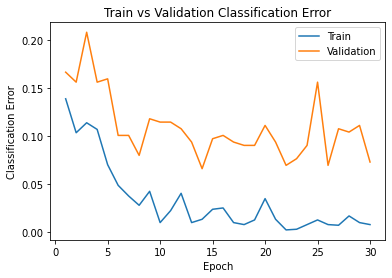

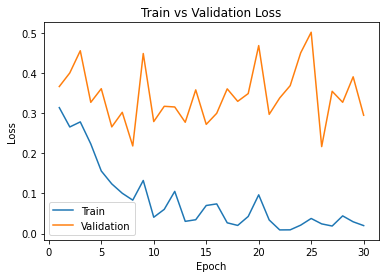

batch size = 32, learning rate = 0.001


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Training with CUDA!
Epoch 1: Train err: 0.15208333333333332, Train loss: 0.31762542492813534 | Val err: 0.19791666666666666, Val loss: 0.37354406383302474 | Time: 47.22
Epoch 2: Train err: 0.12708333333333333, Train loss: 0.28916477494769627 | Val err: 0.13194444444444445, Val loss: 0.34531703260209823 | Time: 94.01
Epoch 3: Train err: 0.12083333333333333, Train loss: 0.26936667992009056 | Val err: 0.2013888888888889, Val loss: 0.39315177665816414 | Time: 140.55
Epoch 4: Train err: 0.10902777777777778, Train loss: 0.24714913732475705 | Val err: 0.15625, Val loss: 0.3847060634030236 | Time: 187.11
Epoch 5: Train err: 0.034027777777777775, Train loss: 0.1153877274857627 | Val err: 0.1076388888888889, Val loss: 0.26897629267639583 | Time: 233.93
Epoch 6: Train err: 0.06319444444444444, Train loss: 0.162874723225832 | Val err: 0.1111111111111111, Val loss: 0.29255061679416233 | Time: 280.52
Epoch 7: Train err: 0.03888888888888889, Train loss: 0.09055629807213943 | Val err: 0.07291666666666

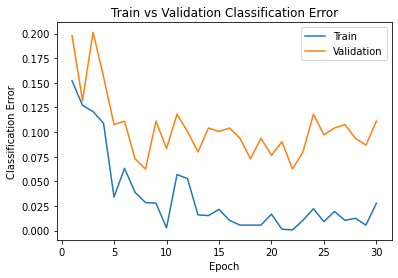

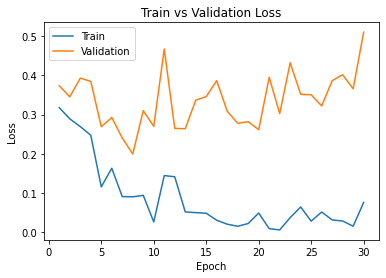

batch size = 64, learning rate = 0.01


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Training with CUDA!
Epoch 1: Train err: 0.11221590909090909, Train loss: 0.2825523452325301 | Val err: 0.1875, Val loss: 0.35889139771461487 | Time: 37.11
Epoch 2: Train err: 0.10369318181818182, Train loss: 0.22577755085446619 | Val err: 0.1328125, Val loss: 0.2827932685613632 | Time: 73.66
Epoch 3: Train err: 0.060369318181818184, Train loss: 0.14917248860001564 | Val err: 0.125, Val loss: 0.27244435995817184 | Time: 109.85
Epoch 4: Train err: 0.046875, Train loss: 0.12671625140038403 | Val err: 0.12109375, Val loss: 0.274050273001194 | Time: 145.94
Epoch 5: Train err: 0.022727272727272728, Train loss: 0.0661310484548184 | Val err: 0.0703125, Val loss: 0.20196868106722832 | Time: 182.09
Epoch 6: Train err: 0.017045454545454544, Train loss: 0.05471221069720658 | Val err: 0.09375, Val loss: 0.26977069675922394 | Time: 218.24
Epoch 7: Train err: 0.019176136363636364, Train loss: 0.053804889913987027 | Val err: 0.1015625, Val loss: 0.29868846759200096 | Time: 254.46
Epoch 8: Train err: 0

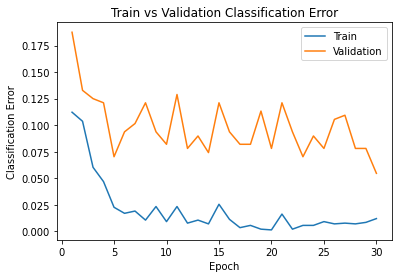

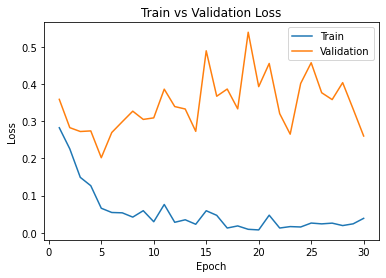

batch size = 64, learning rate = 0.001


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Training with CUDA!
Epoch 1: Train err: 0.13210227272727273, Train loss: 0.28007691489024594 | Val err: 0.15234375, Val loss: 0.3673769608139992 | Time: 36.89
Epoch 2: Train err: 0.05397727272727273, Train loss: 0.16878389770334418 | Val err: 0.12890625, Val loss: 0.2774391733109951 | Time: 73.18
Epoch 3: Train err: 0.09801136363636363, Train loss: 0.2511637237938968 | Val err: 0.109375, Val loss: 0.4012555480003357 | Time: 109.21
Epoch 4: Train err: 0.020596590909090908, Train loss: 0.07419578781859441 | Val err: 0.08984375, Val loss: 0.23276958242058754 | Time: 145.31
Epoch 5: Train err: 0.022727272727272728, Train loss: 0.059316493909467354 | Val err: 0.078125, Val loss: 0.27376462146639824 | Time: 181.39
Epoch 6: Train err: 0.02911931818181818, Train loss: 0.07668470845303753 | Val err: 0.11328125, Val loss: 0.2739386521279812 | Time: 217.49
Epoch 7: Train err: 0.036931818181818184, Train loss: 0.0993059172549031 | Val err: 0.1484375, Val loss: 0.4432072378695011 | Time: 253.62
Epo

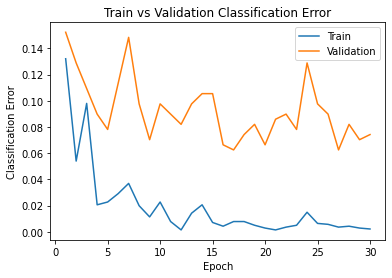

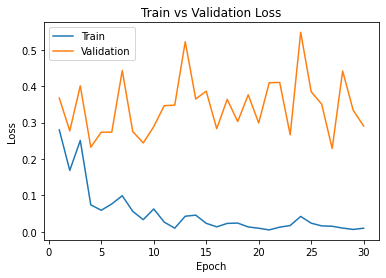

In [ ]:
bs_list = [32, 64]
lr_list = [0.01, 0.001]
for bs in bs_list:
  for lr in lr_list:
    train_loader, val_loader, test_loader, classes = get_data_loader(['Covid Negative', 'Covid Positive'], bs, 1)
    # Train with batch size and learning rate
    print('batch size = {}, learning rate = {}'.format(bs, lr))
    use_cuda = True
    model = TransferDenseNet121Classifier_AdamLRD()
    _, kwargs = split_optim_dict(optim_dict['adam_lrd'])
    optimizer = task_to_optimizer('adam_lrd')(params=model.parameters(), **kwargs)
    optimizer = wrap_optimizer('adam_lrd', optimizer)
    if use_cuda and torch.cuda.is_available():
      model.cuda()
      print("Training with CUDA!")
    else:
      print("CUDA not available...")
    train(model, train_loader, val_loader, optimizer, batch_size=bs, learning_rate=lr, num_epochs=30)

    # Plotting
    model_path = get_model_name('densenet121Classifier_adamLRD', batch_size=bs, learning_rate=lr, epoch=30)
    plot_training_curve(model_path, epochs=30)

Useful Links:  
https://www.kaggle.com/code/jaeboklee/pytorch-transfer-learning-with-densenet/notebook
https://www.upgrad.com/blog/basic-cnn-architecture/  
https://towardsdatascience.com/a-bunch-of-tips-and-tricks-for-training-deep-neural-networks-3ca24c31ddc8  
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8189817/  
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8300985/

https://towardsdatascience.com/creating-densenet-121-with-tensorflow-edbc08a956d8
https://www.kaggle.com/code/portgasray/covid-19-detection-with-x-ray-covid19-pytorch